In [1]:
import torch
import os
import random
import numpy as np

from tqdm import tqdm
from PIL import Image
from diffusers import StableDiffusionPipeline, DDPMScheduler

from config import config
from model import LatentUNet
from pipeline import LatentDDPMPipeline
from evaluate import evaluate, latents_to_pil, make_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [2]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_seed(1)

In [3]:
model = LatentUNet(sample_size=config.sample_size,
                   in_channels=config.in_channels,
                   out_channels=config.out_channels,
                   layers_per_block=config.layers_per_block,
                   block_out_channels=config.block_out_channels, 
                   down_block_types=config.down_block_types, 
                   up_block_types=config.up_block_types,
                   num_artist_class_embeds = config.num_artist_classes,
                   num_genre_class_embeds = config.num_genre_classes,
                   num_style_class_embeds = config.num_style_classes).to(device)

if os.path.exists(config.pretrained_path):
    model = model.from_pretrained(pretrained_model_name_or_path = config.pretrained_path).to(device)
    print("Model weights loaded from step %d" % model.step)
    
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

pipeline = LatentDDPMPipeline(unet=model, scheduler=noise_scheduler)

Trainable Parameters: 108.827M
Trainable Parameters: 108.827M
Model weights loaded from step 3540999


In [19]:
eval_artist_class_labels = [config.artists.index(name) for name in ['martiros-saryan']]
eval_genre_class_labels = [config.genre.index(name) for name in ['landscape']]
eval_style_class_labels = [config.style.index(name) for name in ['Expressionism']]

artist_labels = torch.LongTensor(eval_artist_class_labels).to(device)
genre_labels = torch.LongTensor(eval_genre_class_labels).to(device)
style_labels = torch.LongTensor(eval_style_class_labels).to(device)

# Generate and plot some images:
x = torch.randn(1, config.in_channels, 64, 128).to(device)

for i, t in enumerate(tqdm(noise_scheduler.timesteps)):
    model_input = noise_scheduler.scale_model_input(x, t)
    
    with torch.no_grad():
        noise_pred = pipeline.unet(model_input, t, 
                                   artist_class_labels=artist_labels,
                                   genre_class_labels=genre_labels,
                                   style_class_labels=style_labels).sample
        
    x = noise_scheduler.step(noise_pred, t, x).prev_sample
    
images = latents_to_pil(x)
image_grid = make_grid(images, rows=1, cols=1)

100%|███████████████████████████████████████| 1000/1000 [00:36<00:00, 27.36it/s]


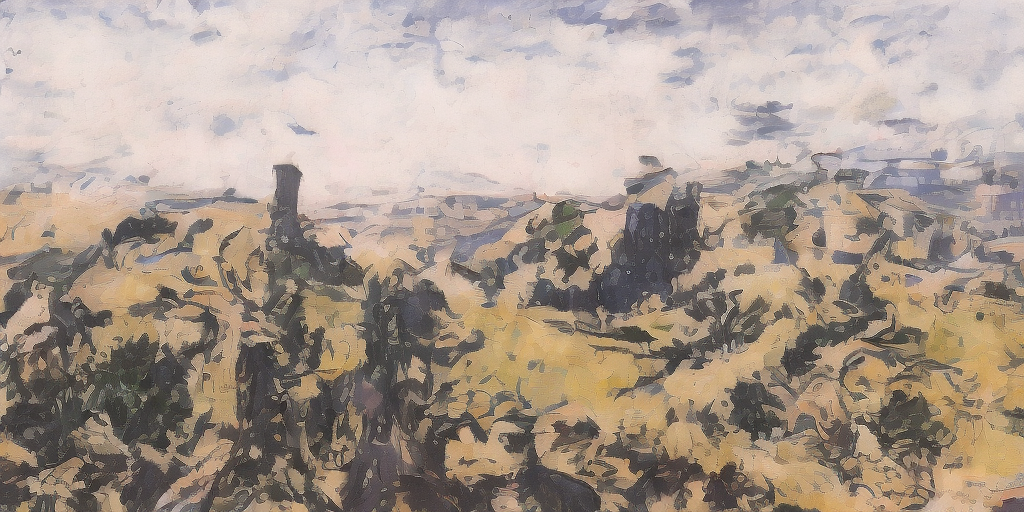

In [20]:
image_grid

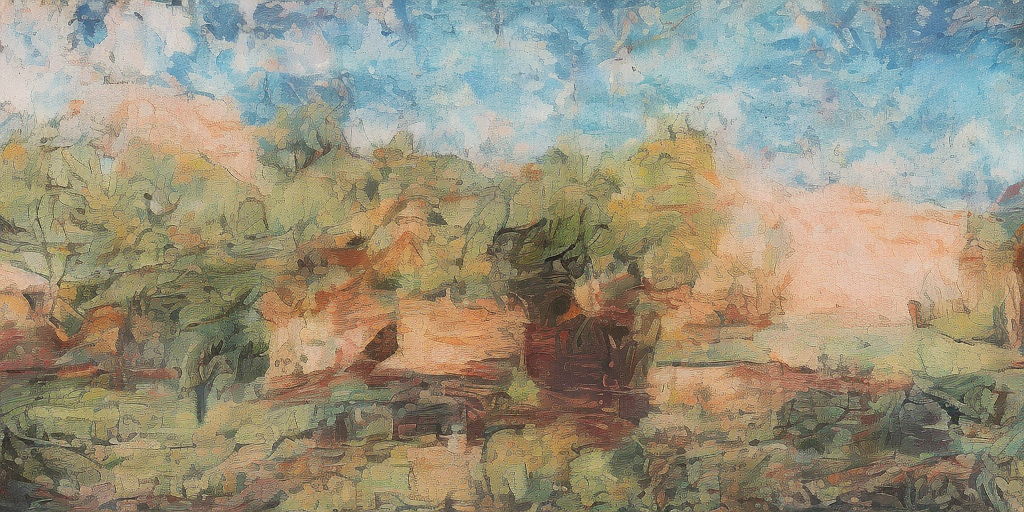

In [51]:
image_grid

In [52]:
eval_artist_class_labels = [config.artists.index(name) for name in ['ivan-aivazovsky']]
eval_genre_class_labels = [config.genre.index(name) for name in ['landscape']]
eval_style_class_labels = [config.style.index(name) for name in ['Romanticism']]

artist_labels = torch.LongTensor(eval_artist_class_labels).to(device)
genre_labels = torch.LongTensor(eval_genre_class_labels).to(device)
style_labels = torch.LongTensor(eval_style_class_labels).to(device)

# Generate and plot some images:
x = torch.randn(1, config.in_channels, 80, 64).to(device)

for i, t in enumerate(tqdm(noise_scheduler.timesteps)):
    model_input = noise_scheduler.scale_model_input(x, t)
    
    with torch.no_grad():
        noise_pred = pipeline.unet(model_input, t, 
                                   artist_class_labels=artist_labels,
                                   genre_class_labels=genre_labels,
                                   style_class_labels=style_labels).sample
        
    x = noise_scheduler.step(noise_pred, t, x).prev_sample
    
images = latents_to_pil(x)
image_grid = make_grid(images, rows=1, cols=1)

100%|███████████████████████████████████████| 1000/1000 [00:27<00:00, 36.60it/s]


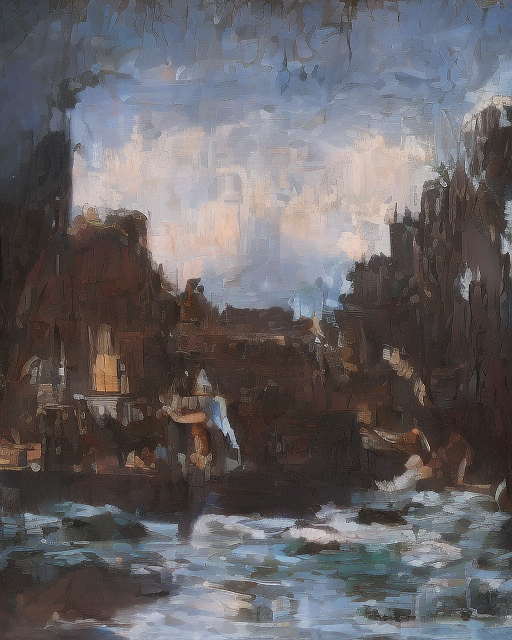

In [45]:
image_grid